## Land Classification
In this notebook, we will use a simple binary Random Forest classifier to classify land into buildings and non-buildings. Satellite data will be donwloaded from Google Earth Engine and used to train the model.

In [1]:
import os
from dotenv import load_dotenv
import requests
import datetime
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import ee
import geemap
import os
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.mask import mask
from rasterio.features import rasterize
from rasterio.warp import calculate_default_transform, reproject, Resampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from glob import glob

In [2]:
# Initialize Earth Engine
try:
    ee.Initialize()
except Exception as e:
    # If not authenticated, authenticate
    ee.Authenticate()
    ee.Initialize()

Now, let us call our boundary file and convert it to an earth engine geometry. As our boundary polygon contains multiple features, we will convert it to a single polygon.

In [21]:
boundary = gpd.read_file("maincity.geojson")

features = []

def gdf_to_ee_geometry(gdf):
    features = []
    for i, row in gdf.iterrows():
        geom = row.geometry
        if geom.geom_type == 'Polygon':
            coords = [list(zip(*geom.exterior.coords.xy))]
            features.append(ee.Geometry.Polygon(coords))
        elif geom.geom_type == 'MultiPolygon':
            for polygon in geom.geoms:
                coords = [list(zip(*polygon.exterior.coords.xy))]
                features.append(ee.Geometry.Polygon(coords))
    
    return ee.FeatureCollection(features).geometry().dissolve()

# Convert boundary to EE geometry
kathmandu_geometry = gdf_to_ee_geometry(boundary)

Now, let us write the function to get landsat imagery and ndvi for our geometry and dates.

In [14]:
def get_landsat_imagery(year, geometry):
    # Set date range to get images from spring (less cloud cover)
    start_date = f"{year}-03-01"
    end_date = f"{year}-05-31"
    
    # Use Landsat 8 for 2013 onwards, Landsat 7 for earlier
    if year >= 2013:
        collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
        # For Landsat 8/9
        nir_band = 'SR_B5'  # NIR
        red_band = 'SR_B4'  # Red
        green_band = 'SR_B3'  # Green
        blue_band = 'SR_B2'  # Blue
    else:
        collection = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
        # For Landsat 7
        nir_band = 'SR_B4'  # NIR
        red_band = 'SR_B3'  # Red
        green_band = 'SR_B2'  # Green
        blue_band = 'SR_B1'  # Blue
    
    # Filter collection by date and location
    filtered = collection.filterDate(start_date, end_date) \
                        .filterBounds(geometry) \
                        .sort('CLOUD_COVER')
    
    # Get the least cloudy image
    image = filtered.first()
    
    if image is None:
        return None
    
    # Calculate NDVI directly in Earth Engine
    ndvi = image.normalizedDifference([nir_band, red_band]).rename('NDVI')
    
    # Get RGB visualization
    rgb_vis = {
        'bands': [red_band, green_band, blue_band],
        'min': 7000,
        'max': 30000
    }
    
    # Get NDVI visualization
    ndvi_vis = {
        'bands': ['NDVI'],
        'min': -0.2,
        'max': 0.8,
        'palette': ['red', 'orange', 'yellow', 'yellowgreen', 'green', 'darkgreen']
    }
    
    return {
        'image': image,
        'ndvi': ndvi,
        'rgb_vis': rgb_vis,
        'ndvi_vis': ndvi_vis,
        'year': year
    }

In [15]:
def download_annual_imagery(start_year, end_year, geometry, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    annual_files = {}
    
    for year in range(start_year, end_year + 1):
        print(f"Processing imagery for {year}...")
        
        result = get_landsat_imagery(year, geometry)
        if result is None:
            print(f"No scenes found for {year}")
            continue
        
        # Create a map to visualize the image
        map_obj = geemap.Map()
        map_obj.centerObject(geometry, 11)
        map_obj.addLayer(result['image'], result['rgb_vis'], f'Landsat {year}')
        
        # Add the geometry boundary
        map_obj.addLayer(ee.FeatureCollection(ee.Feature(geometry)), {'color': 'red'}, 'Boundary')
        
        # Export all bands (RGB + NIR + NDVI) as a GeoTIFF
        file_path = os.path.join(output_dir, f"kathmandu_{year}.tif")
        
        # Get the download URL with RGB visualization
        image = result['image'].visualize(**result['rgb_vis']).clip(geometry)
        url = image.getDownloadURL({
            'name': f'kathmandu_{year}',
            'scale': 30,
            'region': geometry,
            'format': 'GEO_TIFF'
        })
        
        # Download the file
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024*1024):
                    f.write(chunk)
            annual_files[year] = file_path
            print(f"Downloaded {file_path}")
        else:
            print(f"Error downloading image for {year}: {response.status_code}")
    
    return annual_files

In [22]:
output_dir = "data/landsat"

current_year = 2025

start_year = 2023
    
# Get annual scenes
annual_images = download_annual_imagery(start_year, current_year, kathmandu_geometry, output_dir)

Processing imagery for 2023...
Downloaded data/landsat/kathmandu_2023.tif
Processing imagery for 2024...
Downloaded data/landsat/kathmandu_2024.tif
Processing imagery for 2025...
Downloaded data/landsat/kathmandu_2025.tif


Now that my landsat data is calculated, let us train the random forest classifer.

In [23]:
buildings_gdf = gpd.read_file("data/buildings/ktm_buildings.geojson")

In [25]:
landsat_2024 = "data/landsat/kathmandu_2024.tif"

with rasterio.open(landsat_2024) as landsat_src:
    landsat_meta = landsat_src.meta
    landsat_crs = landsat_src.crs
    landsat_transform = landsat_src.transform
    landsat_data = landsat_src.read()
    landsat_bands = landsat_src.count
    
    # Get the bounds of the Landsat image
    landsat_bounds = landsat_src.bounds
    
    print(f"Landsat image has {landsat_bands} bands with shape {landsat_data.shape}")

Landsat image has 3 bands with shape (3, 818, 856)


In [26]:
buildings_gdf = buildings_gdf.to_crs(landsat_crs)

In [27]:
from rasterio.features import rasterize
# Create a binary raster from building footprints
# Get dimensions from Landsat
height = landsat_meta['height']
width = landsat_meta['width']

# Rasterize the buildings (1 where building, 0 elsewhere)
building_shapes = [(geom, 1) for geom in buildings_gdf.geometry]
building_mask = rasterize(
    building_shapes,
    out_shape=(height, width),
    transform=landsat_transform,
    fill=0,
    dtype=np.uint8
)

# Save the building mask for reference
building_mask_meta = landsat_meta.copy()
building_mask_meta.update({
    'count': 1,
    'dtype': 'uint8',
    'nodata': 0
})

with rasterio.open(os.path.join(output_dir, 'building_mask.tif'), 'w', **building_mask_meta) as dst:
    dst.write(building_mask, 1)

Now we prepare the training data

In [28]:
# Reshape Landsat data for ML (bands, height, width) -> (pixels, bands)
n_bands = landsat_data.shape[0]
flat_landsat = landsat_data.reshape(n_bands, -1).T  # Each row is a pixel, each column a band

# Flatten the building mask
flat_mask = building_mask.reshape(-1)

# Remove pixels with nodata in any band
valid_pixels = np.all(flat_landsat > 0, axis=1)
X = flat_landsat[valid_pixels]
y = flat_mask[valid_pixels]

print(f"Valid pixels: {X.shape[0]}, Built-up pixels: {np.sum(y == 1)}")

# Balance the dataset (equal number of built-up and non-built-up pixels)
# Find indices of built-up and non-built-up pixels
built_indices = np.where(y == 1)[0]
non_built_indices = np.where(y == 0)[0]

# Sample from the larger class to match the smaller class size
min_class_size = min(len(built_indices), len(non_built_indices))
# Cap the sample size to prevent memory issues
max_sample_size = min(min_class_size, 10000)

if len(built_indices) > max_sample_size:
    np.random.seed(42)
    built_indices = np.random.choice(built_indices, max_sample_size, replace=False)

if len(non_built_indices) > max_sample_size:
    np.random.seed(42)
    non_built_indices = np.random.choice(non_built_indices, max_sample_size, replace=False)

# Combine sampled indices
sample_indices = np.concatenate([built_indices, non_built_indices])
X_sampled = X[sample_indices]
y_sampled = y[sample_indices]

Valid pixels: 335518, Built-up pixels: 40042


Now, we start training our random forest classifier.

In [29]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.3, random_state=42, stratify=y_sampled
)

# Initialize and train the model
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_split=10, n_jobs=-1,
                       random_state=42)

In [30]:
train_accuracy = rf_model.score(X_train, y_train)
test_accuracy = rf_model.score(X_test, y_test)
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Testing accuracy: {test_accuracy:.4f}")

Training accuracy: 0.7629
Testing accuracy: 0.6923


Our accuracy is around 69%, which is good enough for a simple model.

In [31]:
import os
import numpy as np
import rasterio
import geopandas as gpd

year = 2025
# Define output directory
output_dir = "data/predictions"
os.makedirs(output_dir, exist_ok=True)

# Get the Landsat file path (not a GeoDataFrame)
landsat_file = "data/landsat/kathmandu_2025.tif"

with rasterio.open(landsat_file) as src:
    # Read the data
    year_data = src.read()
    
    # Get number of bands
    n_bands = year_data.shape[0]
    
    # Reshape for prediction (bands, height, width) -> (pixels, bands)
    flat_year_data = year_data.reshape(n_bands, -1).T
    
    # Remove pixels with nodata in any band
    valid_year_pixels = np.all(flat_year_data > 0, axis=1)
    
    # Create an empty prediction array (all zeros)
    predictions = np.zeros(flat_year_data.shape[0], dtype=np.uint8)
    
    # Predict only for valid pixels
    if np.any(valid_year_pixels):
        valid_X = flat_year_data[valid_year_pixels]
        # Make sure rf_model is loaded before this point
        valid_predictions = rf_model.predict(valid_X)
        
        # Fill the predictions array with valid predictions
        predictions[valid_year_pixels] = valid_predictions
    
    # Reshape back to 2D raster
    prediction_raster = predictions.reshape(src.height, src.width)
    
    # Save the prediction
    output_meta = src.meta.copy()
    output_meta.update({
        'count': 1,
        'dtype': 'uint8',
        'nodata': 0
    })
    
    output_path = os.path.join(output_dir, f"built_up_prediction_{year}.tif")
    with rasterio.open(output_path, 'w', **output_meta) as dst:
        dst.write(prediction_raster, 1)

Now, let us create a function to download the NDVI images from google earth engine.

In [32]:
def download_ndvi_images(start_year, end_year, geometry, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    ndvi_files = {}
    
    for year in range(start_year, end_year + 1):
        print(f"Processing NDVI for {year}...")
        
        result = get_landsat_imagery(year, geometry)
        if result is None:
            print(f"No scenes found for {year}")
            continue
        
        # Get NDVI visualization
        ndvi_image = result['ndvi'].visualize(**result['ndvi_vis']).clip(geometry)
        
        # Export NDVI as GeoTIFF
        file_path = os.path.join(output_dir, f"ndvi_{year}.tif")
        
        # Get the download URL
        url = ndvi_image.getDownloadURL({
            'name': f'ndvi_{year}',
            'scale': 30,
            'region': geometry,
            'format': 'GEO_TIFF'
        })
        
        # Download the file
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024*1024):
                    f.write(chunk)
            ndvi_files[year] = file_path
            print(f"Downloaded {file_path}")
        else:
            print(f"Error downloading NDVI for {year}: {response.status_code}")
    
    return ndvi_files

In [33]:
# Call the function to download NDVI images
ndvi_files = download_ndvi_images(2023, 2025, kathmandu_geometry, output_dir)

Processing NDVI for 2021...
Downloaded data/predictions/ndvi_2021.tif
Processing NDVI for 2022...
Downloaded data/predictions/ndvi_2022.tif
Processing NDVI for 2023...
Downloaded data/predictions/ndvi_2023.tif
Processing NDVI for 2024...
Downloaded data/predictions/ndvi_2024.tif
Processing NDVI for 2025...
Downloaded data/predictions/ndvi_2025.tif


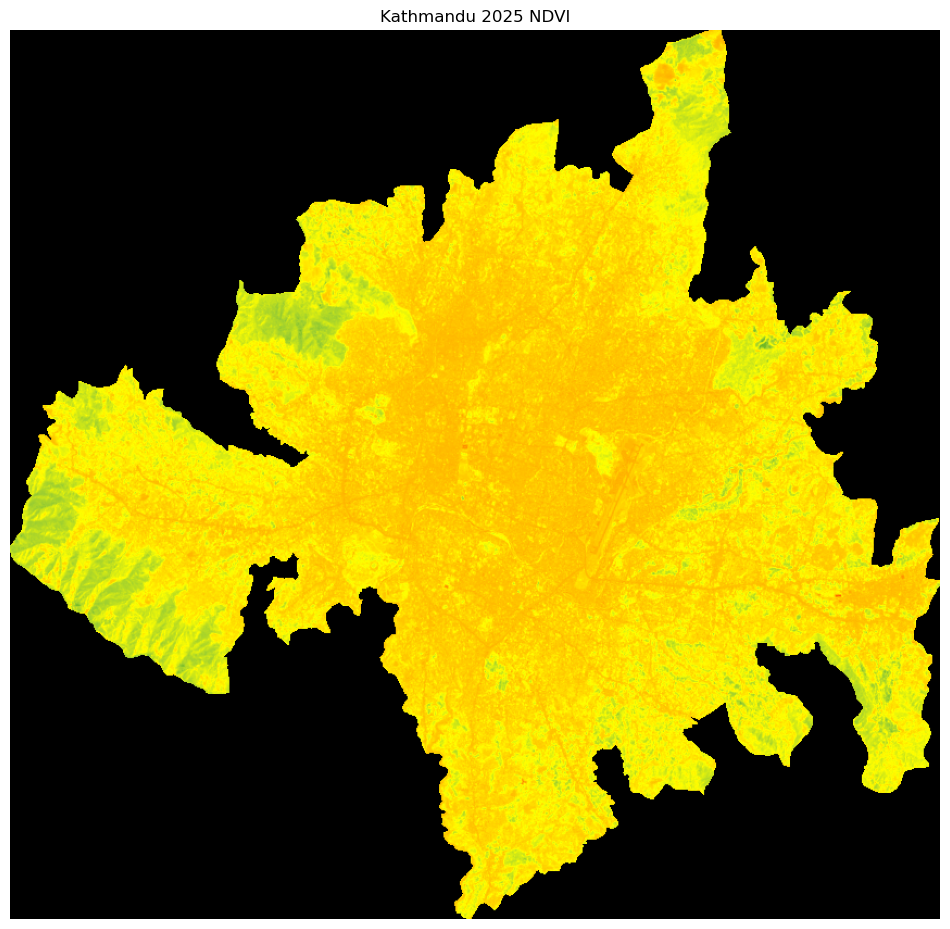

In [42]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from skimage.transform import resize

# File paths
ndvi_file = "data/predictions/ndvi_2025.tif"  
built_up_file = "data/predictions/built_up_prediction_2025.tif" 
output_dir = "data/predictions"
os.makedirs(output_dir, exist_ok=True)

# Read NDVI data
with rasterio.open(ndvi_file) as src:
    ndvi_meta = src.meta
    ndvi_transform = src.transform
    ndvi_data = src.read()
    
    # Handle different NDVI formats
    if ndvi_data.shape[0] == 3:
        # Pre-visualized RGB image
        ndvi_for_display = np.transpose(ndvi_data, (1, 2, 0))
        is_rgb = True
    else:
        # Single-band NDVI raster
        ndvi_for_display = ndvi_data[0]
        is_rgb = False

# Read built-up prediction data
with rasterio.open(built_up_file) as src:
    built_up_data = src.read(1)
    
    # Resize built-up data to match NDVI dimensions
    built_up_for_overlay = resize(
        built_up_data, 
        (ndvi_for_display.shape[0], ndvi_for_display.shape[1]),
        preserve_range=True
    ).astype(np.uint8)


plt.figure(figsize=(12, 12))
plt.imshow(ndvi_for_display)

plt.title('Kathmandu 2025 NDVI')
plt.axis('off')
plt.show()

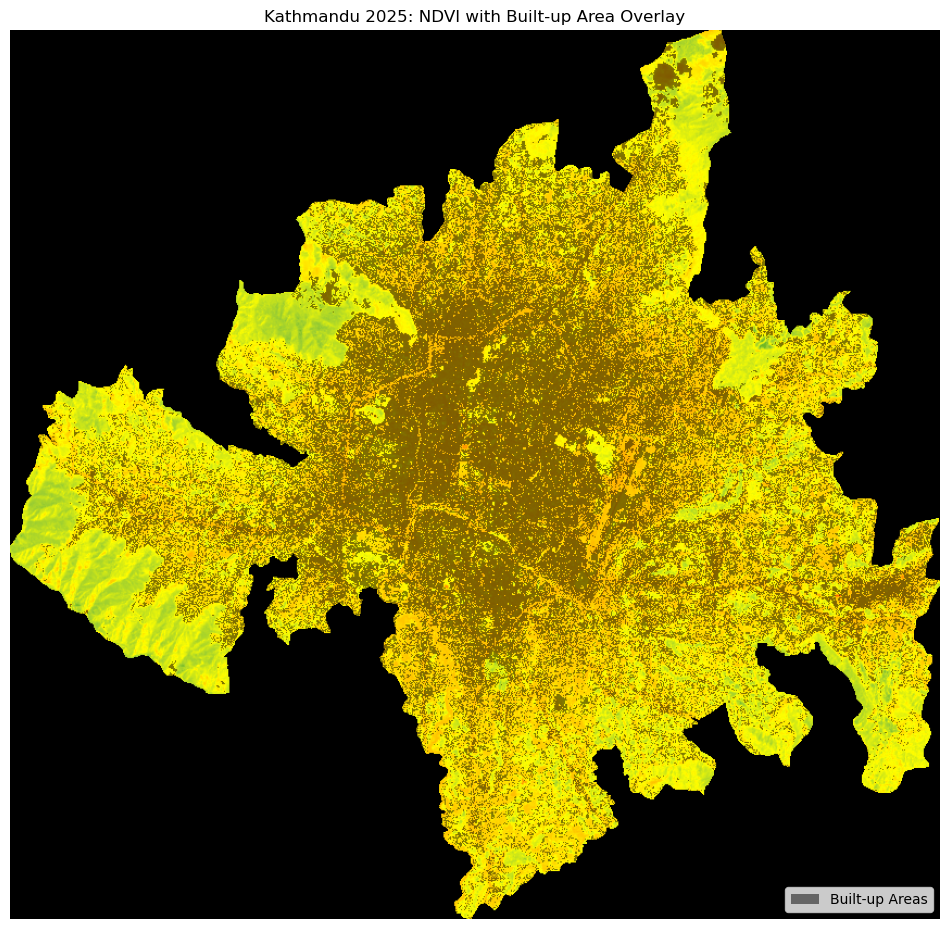

In [43]:
plt.figure(figsize=(12, 12))

plt.imshow(ndvi_for_display)

# Create a masked array for built-up areas
built_up_masked = np.ma.masked_where(built_up_for_overlay == 0, built_up_for_overlay)

# Create a custom colormap for built-up areas
built_up_cmap = ListedColormap(['black'])

# Overlay built-up areas with transparency
plt.imshow(built_up_masked, cmap=built_up_cmap, alpha=0.5)

# Add a legend
legend_elements = [
    mpatches.Patch(facecolor='black', alpha=0.5, label='Built-up Areas')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.title('Kathmandu 2025: NDVI with Built-up Area Overlay')
plt.axis('off')
plt.show()